# Stock return prediction
In this case study we will use various supervised learning-based models to predict the stock price of Microsoft using correlated assets and its own historical data.

## Content

## 1. Problem definition

Supervised regression framework

Predicted variable: Weekly return of the Microsoft stock

For this case study, other than the historical data of MS, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX

## 2. Load libraries and dataset

In [109]:
# Libraries for supervised regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for data analysis and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Libraries for DL models
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

# Libraries for time series models
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# Libraries for data acquisition and visualization
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [110]:
# Load data
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [111]:
stk_data.head()

Attributes Adj Close                   Close                    High           \
Symbols         MSFT      IBM   GOOGL   MSFT      IBM   GOOGL   MSFT      IBM   
Date                                                                            
2017-02-13    60.175  135.772  838.96  64.72  171.472  838.96  64.86  171.989   
2017-02-14    60.400  136.355  840.03  64.57  172.208  840.03  64.72  172.208   
2017-02-15    60.362  137.529  837.32  64.53  173.690  837.32  64.57  173.920   
2017-02-16    60.353  137.339  842.17  64.52  173.451  842.17  65.24  174.751   
2017-02-17    60.447  136.764  846.55  64.62  172.725  846.55  64.69  173.585   

Attributes            Low                    Open                      Volume  \
Symbols      GOOGL   MSFT      IBM   GOOGL   MSFT      IBM   GOOGL       MSFT   
Date                                                                            
2017-02-13  841.74  64.13  170.975  836.25  64.24  171.358  837.70  2.292e+07   
2017-02-14  842.00  64.02  170.507  835.83  64.41  170.717  839.77  2.311e+07   
2017-02-15  841.77  64.16  171.902  836.22  64.50  172.275  838.81  1.701e+07   
2017-02-16  842.69  64.44  172.916  837.26  64.74  173.470  838.50  2.055e+07   
2017-02-17  846.94  64.30  172.084  839.78  64.47  173.279  841.31  2.125e+07   

Attributes                        
Symbols           IBM      GOOGL  
Date                              
2017-02-13  3.236e+06  1.296e+06  
2017-02-14  2.904e+06  1.363e+06  
2017-02-15  3.048e+06  1.357e+06  
2017-02-16  3.401e+06  1.005e+06  
2017-02-17  3.716e+06  1.461e+06

In [112]:
ccy_data.head()

,DEXJPUS,DEXUSUK
DATE,,
2017-02-13,113.79,1.251
2017-02-14,114.34,1.246
2017-02-15,114.17,1.246
2017-02-16,113.36,1.248
2017-02-17,112.86,1.243


In [113]:
idx_data.head()

,SP500,DJIA,VIXCLS
DATE,,,
2017-02-13,2328.25,20412.16,11.07
2017-02-14,2337.58,20504.41,10.74
2017-02-15,2349.25,20611.86,11.97
2017-02-16,2347.22,20619.77,11.76
2017-02-17,2351.16,20624.05,11.49


In [114]:
# 5 business day in a week
return_period = 5

In [115]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period) 
Y.name = Y.name[-1]+'_pred'
Y.head()

Date
2017-02-13    0.002
2017-02-14   -0.003
2017-02-15    0.001
2017-02-16    0.002
2017-02-17   -0.006
Name: MSFT_pred, dtype: float64

In [116]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)
X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

In [117]:
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

## 3. Exploratory data analysis
### 3.1 Descriptive statistics

In [118]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000,225.000,225.000,2.250e+02,2.250e+02,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,0.006,0.004,0.002,1.823e-04,1.631e-04,0.003,0.002,0.001,0.007,0.020,0.040,0.086
std,0.033,0.036,0.039,1.046e-02,1.359e-02,0.027,0.029,0.168,0.032,0.056,0.063,0.072
min,-0.137,-0.131,-0.173,-5.226e-02,-6.616e-02,-0.141,-0.167,-0.442,-0.137,-0.240,-0.299,-0.143
25%,-0.014,-0.017,-0.015,-5.303e-03,-6.979e-03,-0.008,-0.009,-0.103,-0.011,-0.006,0.011,0.047
50%,0.008,0.007,0.003,7.047e-04,-6.658e-04,0.005,0.005,-0.017,0.009,0.023,0.045,0.090
75%,0.026,0.025,0.021,5.920e-03,7.634e-03,0.015,0.016,0.089,0.023,0.048,0.078,0.132
max,0.164,0.096,0.175,5.273e-02,7.540e-02,0.160,0.183,0.651,0.164,0.245,0.207,0.293


In [119]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-05-10,-0.021,0.007,-0.038,0.015,1.779e-03,0.005,-7.059e-04,-0.045,0.003,6.359e-02,0.060,0.075
2017-05-17,0.019,-0.013,-0.002,-0.023,3.864e-04,-0.018,-1.618e-02,0.423,-0.021,5.422e-04,0.032,0.051
2017-05-24,0.019,0.037,0.010,0.005,-6.955e-04,0.020,1.949e-02,-0.442,0.019,1.218e-03,0.055,0.078
2017-06-01,0.026,0.011,0.001,-0.004,-4.643e-03,0.006,2.900e-03,-0.010,0.019,1.705e-02,0.081,0.091
2017-06-09,-0.005,-0.026,0.013,0.001,-1.155e-02,-0.003,3.092e-03,0.093,-0.020,3.782e-02,0.035,0.088


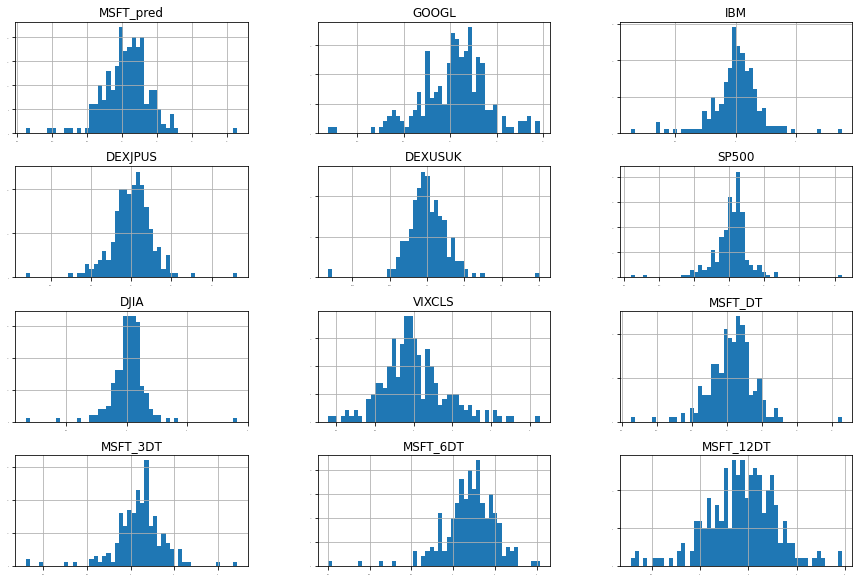

In [120]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(15, 10))
pyplot.show()

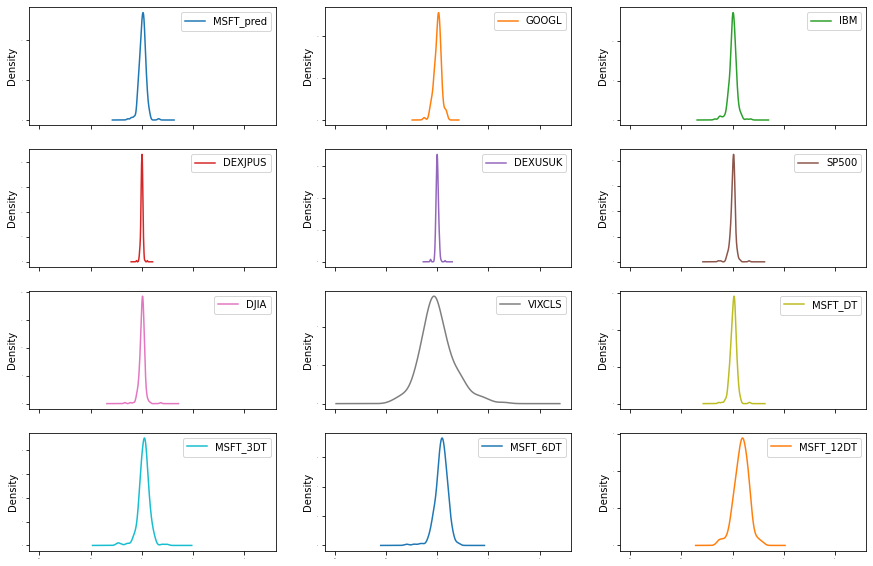

In [121]:
dataset.plot(kind='density', subplots=True, layout=(4, 3), sharex=True, legend=True, fontsize=1, figsize=(15,10))
pyplot.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

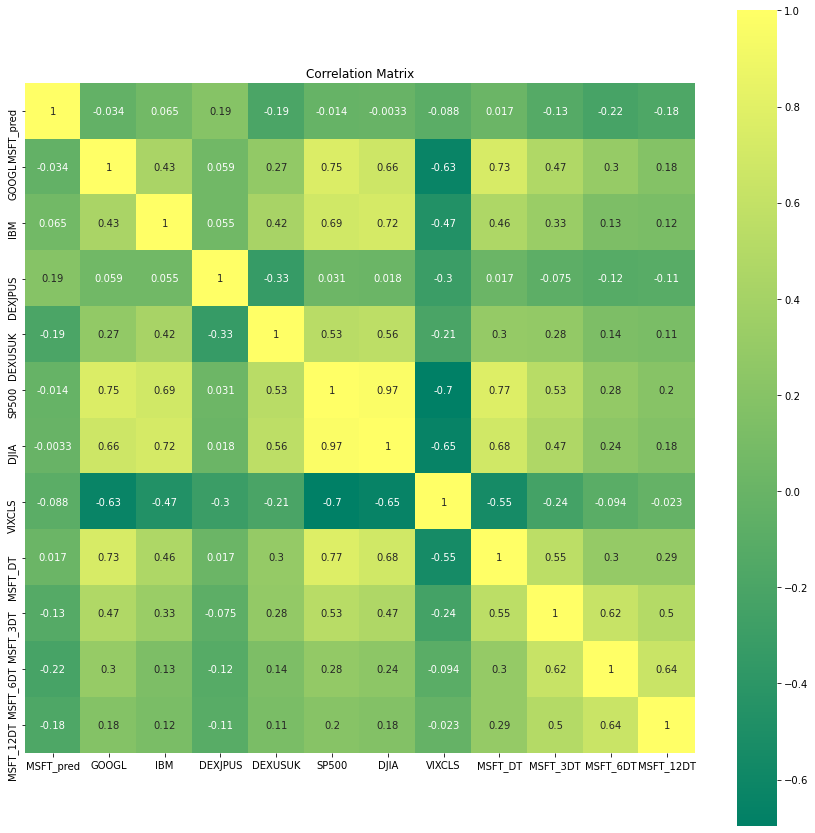

In [122]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='summer')

<Figure size 1080x1080 with 0 Axes>

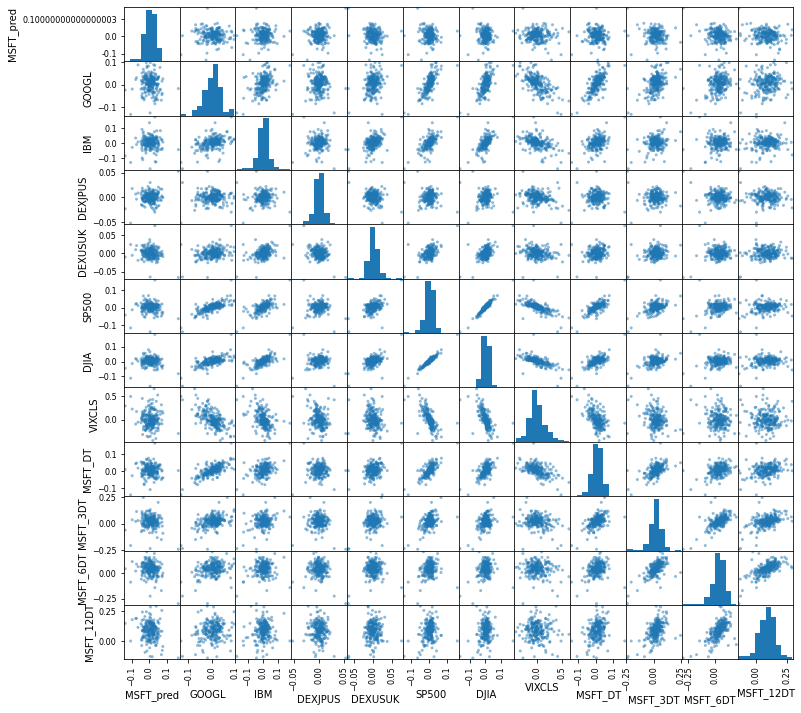

In [123]:
pyplot.figure(figsize=(15,15))
pd.plotting.scatter_matrix(dataset, figsize=(12,12))
pyplot.show()

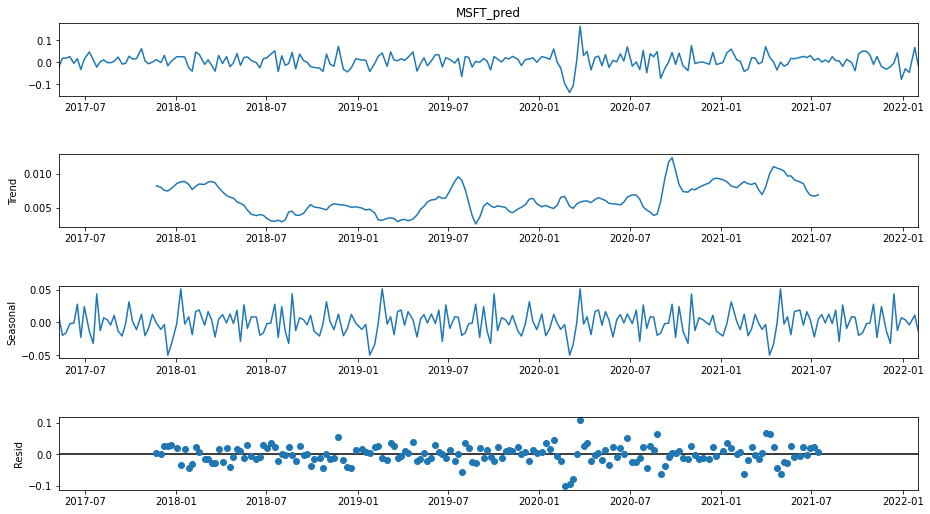

In [124]:
res = sm.tsa.seasonal_decompose(Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We can see that for MSFT there has been a general trend upwards. This should show up in our the constant/bias terms in our models

## 4. Data preparation

## 5. Evaluate algorithms and models
### 5.1 Train test split and evaluation metrics

In [127]:
validation_size = 0.2

#Select an arbitrary split point in the ordered list of observations and creat two new datasets.
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

### 5.2 Test options and evaluation metrics

In [137]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

### 5.3 Compare models and algorithm
#### 5.3.1 Machine learning models from scikit-learn

In [138]:
# Regression and tree regression algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

# Neural network algorithm
models.append(('MLP', MLPRegressor()))

# Ensemble models - Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

# Ensemble models - Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [141]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    ## K fold analysis
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    # Converted mean square error to positive. 
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    # Full training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001219 (0.000547) 0.000948 0.000949
LASSO: 0.001133 (0.000489) 0.001125 0.000859
EN: 0.001133 (0.000489) 0.001125 0.000859
KNN: 0.001469 (0.000616) 0.000988 0.000936
CART: 0.002730 (0.001333) 0.000000 0.001336
SVR: 0.001326 (0.000908) 0.001038 0.000995
MLP: 0.002621 (0.001122) 0.002156 0.002383
ABR: 0.001459 (0.000641) 0.000605 0.000957
GBR: 0.001820 (0.001044) 0.000095 0.001105
RFR: 0.001456 (0.000674) 0.000189 0.000980
ETR: 0.001541 (0.000776) 0.000000 0.000919


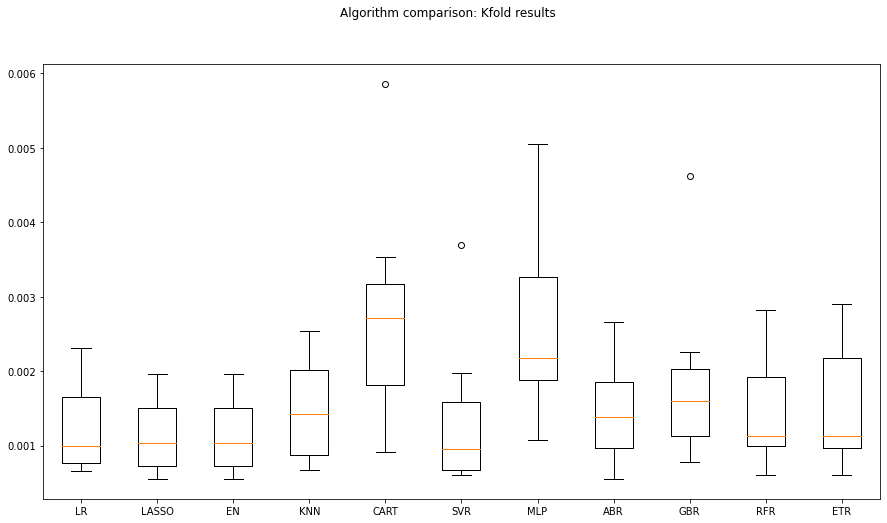

In [144]:
fig = pyplot.figure()
fig.suptitle('Algorithm comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.show()

We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

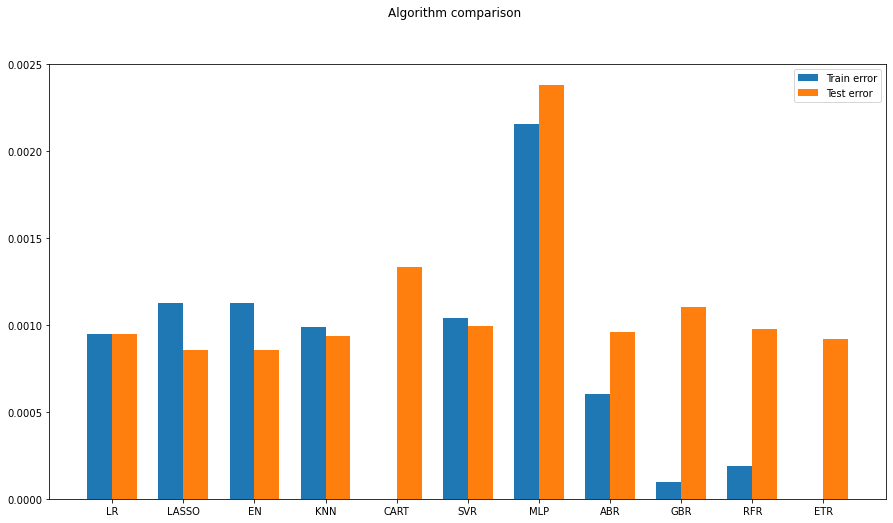

In [146]:
# Compare algorithms
fig  = pyplot.figure()

ind = np.arange(len(names))    #the x locations for the groups
width = 0.35    #the width of the bars

fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label='Train error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test error')
fig.set_size_inches(15, 8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we still see a better performance of the linear models. 
Some of the algorithms, such as the decision tree regressor (CART) overfit on the training data and produced very high error on the test set and these models should be avoided. 
Ensemble models, such as gradient boosting regression (GBR) and random forest regression (RFR) have low bias but high variance. 
We also see that the artificial neural network (shown as MLP is the chart) algorithm shows higher errors both in training set and test set, which is perhaps due to the linear relationship of the variables not captured accurately by ANN or improper hyperparameters or insufficient training of the model.